In [1]:
#Imports
from transformers import BertConfig, BertForMaskedLM, BertPreTrainedModel, BertModel, PreTrainedTokenizerFast, DataCollatorForLanguageModeling, BertPreTrainedModel
from transformers import Trainer, TrainingArguments

from packaging import version
import datasets
import torch.nn as nn
from tokenizers import Tokenizer
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import wandb
import time
import os
from typing import Any, Optional, Tuple, Union
from collections import OrderedDict
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

from torch.nn import CrossEntropyLoss
from utils.NSP_source_code import *
from utils.computeMDE import *

/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Compatability is tuned on Maestro only
dataset_choice = 'Maestro'

In [3]:
dataset_map = {"Chopin43": '_C', 
               "ChopinAndHannds": '_CH',
               "Maestro": '_M'}
Key = dataset_map[dataset_choice]
handConfigNumsMap = {"Chopin43": 110, 
               "ChopinAndHannds": 136,
               "Maestro": 12047}


MDEDir = './Extracted_Repns/MDE' + Key
CompatDir = './Datasets/Compat/'

Load the hand configuration dictionary from when the MDE dataset was created

In [4]:
with open(MDEDir +'/dict/handConf_dict', 'rb') as handle:
    hands = pickle.load(handle)

### Use the hand configuration dict and the computeMDE functions to convert the compatibility MIDI files to MDE representations

First, iterate through the compatibility directory and accumulate files

In [5]:
import os
midiFiles = []
for root, dirs, files in os.walk(CompatDir):
    for file in files:
        if ".mid" in file:
            name = root  + '/' + file
            midiFiles.append(name)

Visualize one of the samples

/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


'./Datasets/Compat/MIDI/p1m55-0.mid'

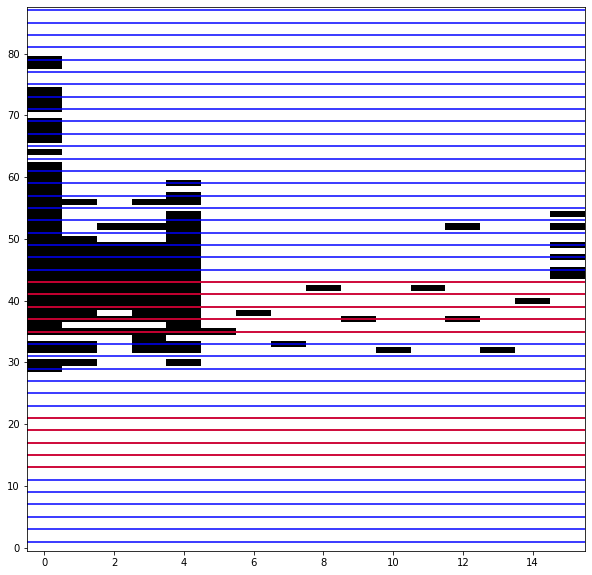

In [6]:
q = calculateQANONForCompat(midiFiles[11], visualize=True)
midiFiles[11]

### There is currently a bug in the compatibility dataset. Some samples (which should all be a measure long) are instead the entire piece and have hundreds of note onsets. Also, some samples have very strange concurrent notes like: './Datasets/Compat/MIDI/p1m55-0.mid'. As a temporary measure, the following code only saves the samples with 16 or less onsets

In [7]:
lengths = []
labels = []
MDEs = []
count = 0
maxlen = 0
badIDX = 0

for idx, file in enumerate(midiFiles):
    q = calculateQANONForCompat(midiFiles[idx])
    label = midiFiles[idx][-5]
    
    
    MDE = computeMDE_from_QANON(q, hands)
    

    
    x = len(MDE.split(' '))
    if x>16:
        count+=1
    else:
        if x>maxlen:
            maxlen = x
            badIDX = idx
        MDEs.append(MDE)
        labels.append(label)
        
        lengths.append(x)
        

In [8]:
maxlen

16

Text(0.5, 0, 'File number')

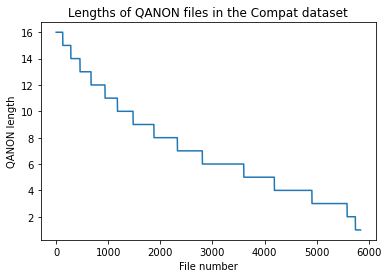

In [9]:
plt.plot(sorted(lengths, reverse=True))
plt.title("Lengths of QANON files in the Compat dataset")
plt.ylabel("QANON length")
plt.xlabel("File number")

# Setting up MDE BERT
The MDE representation consists of 3 things for every note onset in a piece:
1. The pitch of the lowest note (a number 1-12 corresponding to A, A#, ....)
2. The octave of the lowest note (a number 0-7 corresponding to which octave on the piano)
3. The hand configuration (a number 0-136 that maps to a of hand configurations)

To feed this information into BERT with standard huggingface components, I am using an intermediate, proxy tokenizer. At each step, the three elements are concatenated with a separation character. For example, a step with pitch 6, octave 2, and hand configuration 12 becomes 6s2s12. With this intermediate step, the sequence is dimension (1, max_seq_len) instead of (3, max_seq_len), so the default huggingface tokenizers, collators, and trainers can be used.

Within the modified components, there are 3 separate embedding layers at the encoder and decoder(we effectively have three separate vocabularies). The first step in the encoder is to convert the MDE representation(ie. 6s2s12) back to a separate pitch, octave, hand representation so that it can be passed throgh three separate embedding layers.The outputs of the embedding layers can then be summed so that input to the attention layers has the normal shape (768). The decoder then has to have three separate linear layers to map the hidden state back to pitch, octave, hand.

In order to make these changes in huggingface, we need to construct a custom encoder by modifying the BertEmbedding layer, and a custom decoder by modifying the BertLMPredictionHead. We also need to modify the BertForMaskedLM model itself so that the forward function expects three outputs.



# Unmodified huggingface functions

Many things are used by the three huggingface components we are modifying(embeddings, prediction head, and maskedLM), but not all of them are importable from transformers. The code for these are imported from NSP_source_code.py

### Custom encoder

In [10]:
class CustomBertEmbeddings(nn.Module):
    """Construct the embeddings from octave, pitch, hand configuration, and position."""

    def __init__(self, config):
        super().__init__()
        #Get the mapping from token to encoded representation
        self.decoder = {value:key for key, value in config.decoder.items()}
        
        #Aggregate special tokens
        self.maskToken = config.decoder['[MASK]']
        self.unkToken = config.decoder['[UNK]']
        self.sepToken = config.decoder['[SEP]']
        self.padToken = config.decoder['[PAD]']
        self.clsToken = config.decoder['[CLS]']
        self.specialTokens = [self.maskToken, self.unkToken, self.sepToken, self.padToken, self.clsToken]
        
        #Declare embedding layers
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.pitch_embeddings = nn.Embedding(config.numPitches, config.hidden_size)
        self.handConfig_embeddings = nn.Embedding(config.numConfigs, config.hidden_size)
        self.octave_embeddings = nn.Embedding(config.numOctaves, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        if version.parse(torch.__version__) > version.parse("1.6.0"):
            self.register_buffer(
                "token_type_ids",
                torch.zeros(self.position_ids.size(), dtype=torch.long),
                persistent=False,
            )

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        #Custom code to use 3 embedding layers
        #Convert the tokenized MDE representation ie 9s2s55 to pitch=9 octave=2 hand=55 for all tokens in the batch
        octaves = []
        pitches = []
        handConfs = []
        #Iterate through the batch
        for x in input_ids:
            #For each sequence, make a list to store the octave, pitch, and handConf ids
            octave = []
            pitch = []
            handConf = []
            #Iterate through the sequence
            for y in x:
                #If the token is not a special token, decode into the octave_pitch_handConf representation
                if y.item() not in self.specialTokens:
                    #Split on s
                    try:
                        code = [int(x) for x in self.decoder[y.item()].split('s')]
                    except:
                        code = [x for x in self.decoder[y.item()].split('s')]
                        print(code)
                    #Add each element to the correct list
                    octave.append(code[0])
                    pitch.append(code[1])
                    handConf.append(code[2])
                else:
                    #Otherwise, make a representation from the special token. ie: a cls token(1) becomes 1_1_1
                    octave.append(y.item())
                    pitch.append(y.item())
                    handConf.append(y.item())
            #Aggregate the samples in the batch
            octaves.append(octave)
            pitches.append(pitch)
            handConfs.append(handConf)
            
        device = input_ids.device if input_ids is not None else inputs_embeds.device
        
        #Convert the lists to tensors and put them on the gpu
        octTensor = torch.LongTensor(octaves).to(device)
        pitchTensor = torch.LongTensor(pitches).to(device)
        handConfTensor = torch.LongTensor(handConfs).to(device)
        
        #Sum the three embeddings
        input_embeds = self.handConfig_embeddings(handConfTensor)\
                       +self.octave_embeddings(octTensor)\
                       +self.pitch_embeddings(pitchTensor)
        embeddings = input_embeds

        #Standard BertEmbeddings code
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]
        
        if position_ids is None:
            position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(input_shape)
        position_embeddings = self.position_embeddings(position_ids)
        embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

### Custom Configuration

In order for the encoder and MaskedLM to access the dictionary between MDE representation and tokens, we need to pass that in the model's config

In [11]:
class CustomBertConfig(BertConfig):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        #The decoder holds the conversion back to the coded representation for the customEmbeddings layer
        self.decoder = kwargs.get('decoder')
        self.numOctaves = 9
        self.numConfigs = handConfigNumsMap[dataset_choice]
        self.numPitches = 12

#### Setup training

In [12]:
wandb.login()
#1dd35d404a289e1e49f18069e4fe0a51d28d52c7

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mconati (use `wandb login --relogin` to force relogin)


True

In [30]:
#Load the tokenizer
TOKENIZER_SAVEDIR = Path(MDEDir + '/tokenizer')
LM_MODEL_SAVEDIR = Path(MDEDir + '/model/Compat')
Path(LM_MODEL_SAVEDIR).mkdir(exist_ok=True)

In [14]:
print('Cuda available: ', torch.cuda.is_available())
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

Cuda available:  True


[<torch.cuda.device at 0x7f152a774210>, <torch.cuda.device at 0x7f152a7746d0>]

Load the tokenizer from the LM pretraining task

In [15]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_SAVEDIR)
tokenizer

PreTrainedTokenizer(name_or_path='Extracted_Repns/MDE_M/tokenizer', vocab_size=28013, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

#### Setup the model

In [29]:
#Define parameters of the training

MAX_LEN = 16 #max length of training sequences
NUM_EPOCHS = 1 #This model converges very quickly (currently)
BATCH_SIZE = 160


In [17]:
config = CustomBertConfig(
    #The decoder holds the conversion back to the coded representation for the customEmbeddings layer
    decoder = tokenizer.vocab,
    vocab_size=len(tokenizer.vocab),
)
len(tokenizer.vocab)

28013

The model is a standard BertForSequenceClassification model with a replaced embeddings layer

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

mpath = MDEDir + '/best/model' #A model could also be in the /model/checkpoint-#### folder

model = BertForSequenceClassification.from_pretrained(
    mpath,
    config=config
)
device = model.device

temp = CustomBertEmbeddings(config).to(device)
#Replace the model's embedding layer
model.bert.embeddings = temp


mdict = torch.load(mpath + '/pytorch_model.bin')

model.load_state_dict(mdict, strict = False)

Some weights of the model checkpoint at ./Extracted_Repns/MDE_M/best/model were not used when initializing BertForSequenceClassification: ['cls.predictions.decode_hand.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias_h', 'cls.predictions.decode_pitch.bias', 'bert.embeddings.pitch_embeddings.weight', 'cls.predictions.decode_octave.bias', 'cls.predictions.bias_p', 'cls.predictions.transform.dense.weight', 'bert.embeddings.handConfig_embeddings.weight', 'bert.embeddings.octave_embeddings.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decode_pitch.weight', 'cls.predictions.decode_octave.weight', 'cls.predictions.decode_hand.weight', 'cls.predictions.bias_o']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).


_IncompatibleKeys(missing_keys=['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias'], unexpected_keys=['cls.predictions.bias_p', 'cls.predictions.bias_o', 'cls.predictions.bias_h', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decode_pitch.weight', 'cls.predictions.decode_pitch.bias', 'cls.predictions.decode_octave.weight', 'cls.predictions.decode_octave.bias', 'cls.predictions.decode_hand.weight', 'cls.predictions.decode_hand.bias'])

Take the MDEs extracted from the Compat directory, shuffle them, and convert them into a huggingface dataset

In [19]:
temp = list(zip(labels, MDEs))
random.shuffle(temp)
labels, MDEs = zip(*temp)

split = int(0.8*len(labels))

t_labels = labels[:split]
v_labels = labels[split:]

t_MDEs = MDEs[:split]
v_MDEs = MDEs[split:]

t_dataset_dict = {}
v_dataset_dict = {}

t_dataset_dict['labels'] = [int(x) for x in t_labels]
t_dataset_dict['text'] = t_MDEs

v_dataset_dict['labels'] = [int(x) for x in v_labels]
v_dataset_dict['text'] = v_MDEs

In [20]:
def tokenize_function(examples):

    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = MAX_LEN+2)

 Tokenize the dataset and make sure that samples look as expected:
 1. A label 1 or 0 for positive or negative match
 3. A sequence of tokens representing MDE audio
 4. CLS, SEP, and PAD tokens

In [21]:
from datasets import Dataset

v_dataset = Dataset.from_dict(v_dataset_dict)
t_dataset = Dataset.from_dict(t_dataset_dict)

tokenized_v_datasets = v_dataset.map(tokenize_function, batched=True)
tokenized_t_datasets = t_dataset.map(tokenize_function, batched=True)

100%|██████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64ba/s]


In [22]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
tokenized_v_datasets[0]

{'labels': 0,
 'text': '3s1s61 3s1s646 3s1s29 5s6s1 5s4s1 5s5s1 5s8s1 5s10s1',
 'input_ids': [1,
  3058,
  22970,
  2601,
  33,
  24,
  27,
  36,
  39,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]}

In [27]:
training_args = TrainingArguments(
    output_dir=LM_MODEL_SAVEDIR,
    overwrite_output_dir=True,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    save_steps=100,
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_total_limit=1,
    prediction_loss_only=False,
    report_to="wandb",
    load_best_model_at_end = True
)

PyTorch: setting up devices


In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_t_datasets,
    eval_dataset=tokenized_v_datasets,
)
trainer.args

TrainingArguments(
_n_gpu=2,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=10,
evaluation_strategy=IntervalStrategy.STEPS,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=True,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=Extracted_Repns/MDE_M/

# This model converges very quickly (and starts to diverge). I am a little doubtful of the training curve

In [26]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4673
  Num Epochs = 2500
  Instantaneous batch size per device = 160
  Total train batch size (w. parallel, distributed & accumulation) = 320
  Gradient Accumulation steps = 1
  Total optimization steps = 37500
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: WARNING Serializing object of type dict that is 1310824 bytes
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
10,0.640100,0.685656
20,0.562000,0.490432
30,0.431600,0.462813
40,0.326800,0.451634
50,0.236400,0.467624
60,0.196600,0.447303
70,0.129000,0.603621
80,0.125300,0.533074
90,0.103700,0.566314
100,0.076900,0.629068


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1169
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1169
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1169
  Batch size = 16
The follow

KeyboardInterrupt: 